In [1]:
import random
import networkx as nx
import gzip
import pandas as pd
import matplotlib.pyplot as plt

(i) research questions and motivations


- Community Detection: What are the most densely connected subgraphs (communities) within the Wikipedia graph? How do these communities correspond to real-world domains of knowledge?

- Centrality Measures: Which Wikipedia pages (nodes) are most central in the graph according to various centrality measures (e.g., degree centrality, betweenness centrality, eigenvector centrality)? How do these central nodes correlate with the importance or influence of the corresponding topics in human knowledge?

- Shortest Path Analysis: What are the average shortest paths between nodes in the graph? How does this reflect the 'six degrees of separation' concept? Are certain areas of knowledge more interconnected than others?

- PageRank and Authority: Using algorithms like PageRank, which pages emerge as the most authoritative or influential? How does this compare to the perceived importance of these topics in academia or popular culture?

- Clustering Coefficient: What is the clustering coefficient of the Wikipedia graph, and what does this tell us about the tendency of knowledge areas to cluster together?

- Graph Visualization: How can we effectively visualize portions of this large graph to gain insights into the structure of human knowledge?




(ii) suggested data collection

- from snap datasets, networkx



(iii) intended methodology

- find interesting things




# open file and create graph

In [2]:
with gzip.open('wiki-topcats.txt.gz', 'rt') as f:
    G = nx.DiGraph()

    for line in f:
        if line.startswith('#') or not line.strip():
            continue
        
        source, target = line.strip().split()
        
        G.add_edge(source, target)

In [3]:
G.number_of_nodes(), G.number_of_edges()

(1791489, 28511807)

# parsing functions

## maps node id to node name

In [4]:
def create_node_to_article_mapping(file_path, delimiter=' '):
   
    mapping = {}
    with gzip.open(file_path, 'rt') as file:
        for line in file:
            parts = line.strip().split(delimiter)
            if len(parts) >= 2:
                node_number = parts[0]
                article_name = delimiter.join(parts[1:])
                mapping[node_number] = article_name
    return mapping

file_path = 'wiki-topcats-page-names.txt.gz'

mapping_n2a = create_node_to_article_mapping(file_path)

def article_name(node_number, mapping=mapping_n2a):
   
    return mapping.get(node_number)





## node to categories

In [5]:
def create_node_to_category_mapping(file_path):
    mapping = {}
    with gzip.open(file_path, 'rt') as file:
        for line_number, line in enumerate(file, start=1):
            if line.startswith('Category:'):
                try:
                    category, nodes = line.strip().split('; ')
                    category = category.replace('Category:', '')
                    nodes = nodes.split()
                    for node in nodes:
                        node_number = int(node)
                        if node_number not in mapping:
                            mapping[node_number] = []
                        mapping[node_number].append(category)
                except ValueError as e:
                    pass
    return mapping


file_path = 'wiki-topcats-categories.txt.gz'
node_to_category_mapping = create_node_to_category_mapping(file_path)

def node_cats(node_number, mapping=node_to_category_mapping):
    
    return mapping.get(int(node_number), [])



node_cats(26346)


['17th-century_Roman_Catholic_priests',
 'Roman_Catholic_missionaries',
 'Italian_Roman_Catholic_priests',
 '17th-century_Italian_people']

In [6]:
article_name('123'),node_cats('123')

('Leon Burns',
 ['People_from_Oakland,_California',
  'People_murdered_in_California',
  'American_murder_victims',
  'Unsolved_murders_in_the_United_States',
  'San_Diego_Chargers_players',
  'American_football_running_backs',
  'St._Louis_Cardinals_(football)_players'])

# ways to sample the graph
- random node or random edge, 
subset of edges preservers more structure than subset of nodes
- BFS, start from a node and go a certain depth around it
- snowball, similar to BFS but limit the number of nodes sampled
- degree-based, select all nodes within Nth degree

## random nodes

In [11]:
sg = G.subgraph(random.sample(list(G.nodes()), 10000))

In [12]:
sg.number_of_edges(), sg.number_of_nodes()

(799, 10000)

## BFS

In [13]:
start_node = random.choice(list(G.nodes()))

# Initialize BFS
visited = set()  # To keep track of visited nodes
queue = [(start_node, 0)]  # Queue for BFS, with node and depth
nodes_within_3_degrees = set()

# Perform BFS up to 3 degrees
while queue:
    current_node, depth = queue.pop(0)
    if depth > 1:
        # Stop if depth is greater than 3
        break
    visited.add(current_node)
    nodes_within_3_degrees.add(current_node)

    # Add neighbors to the queue
    for neighbor in G.neighbors(current_node):
        if neighbor not in visited:
            visited.add(neighbor)
            queue.append((neighbor, depth + 1))

# Create the subgraph
subgraph = G.subgraph(nodes_within_3_degrees)

In [14]:
article_name(start_node)

'KOJY'

In [15]:
subgraph.number_of_nodes(), subgraph.number_of_edges()

(7, 7)

In [16]:
subgraph.nodes()

NodeView(('264656', '264610', '262059', '262499', '281046', '264193', '281145'))

## snowball sampling

In [17]:
def snowball_sample(graph, start_node=None, max_size=100):
    if start_node is None:
        start_node = random.choice(list(graph.nodes()))

    sampled_nodes = set([start_node])
    queue = [start_node]

    while queue and len(sampled_nodes) < max_size:
        current_node = queue.pop(0)
        neighbors = list(graph.neighbors(current_node))
        random.shuffle(neighbors)

        for neighbor in neighbors:
            if neighbor not in sampled_nodes:
                sampled_nodes.add(neighbor)
                queue.append(neighbor)

            if len(sampled_nodes) >= max_size:
                break

    return graph.subgraph(sampled_nodes)

In [20]:
start_node = random.choice(list(G.nodes()))  # Optional: choose a specific start node
subgraph = snowball_sample(G, start_node, 1000)
start_node, article_name(start_node)


('962265', 'Leo Fischer')

In [21]:
subgraph = nx.Graph(subgraph)
subgraph.remove_node('1783670')

NetworkXError: The node 1783670 is not in the graph.

In [22]:
articles = [article_name(x) for x in list(subgraph.nodes())]
cats_of_articles = [node_cats(x) for x in list(subgraph.nodes())]
combined = dict(zip(articles, cats_of_articles))


In [23]:
df = pd.DataFrame.from_dict(dict(subgraph.degree), orient='index', columns=['degree']).sort_values('degree', ascending=False)
df['article'] = df.index.map(article_name)
df['distance_from_source'] = df.index.map(nx.single_source_shortest_path_length(subgraph, start_node))
#df.sort_values('distance_from_source', inplace=True, ascending=False)
df['betweenness_centrality'] = df.index.map(nx.betweenness_centrality(subgraph))
df.sort_values('betweenness_centrality', inplace=True, ascending=False)
articulation_points = [article_name(x) for x in list(nx.articulation_points(subgraph))]
labels = {node: article_name(node) for node in list(nx.articulation_points(subgraph))}


In [24]:
df

,degree,article,distance_from_source,betweenness_centrality
279122,997,United States,1,0.999237
1387565,27,Chicago,1,0.001732
962265,5,Leo Fischer,0,0.001372
1063983,3,Allan Carr,2,0.000388
1164402,2,Joey (TV series),2,0.000388
...,...,...,...,...
1291620,1,Angel (Aerosmith song),2,0.000000
1680745,1,Jeanie Johnston,2,0.000000
265680,1,Hendrie River,2,0.000000
251736,1,Building at 813-815 W. Second Street,2,0.000000


In [25]:
labels

{'279122': 'United States'}

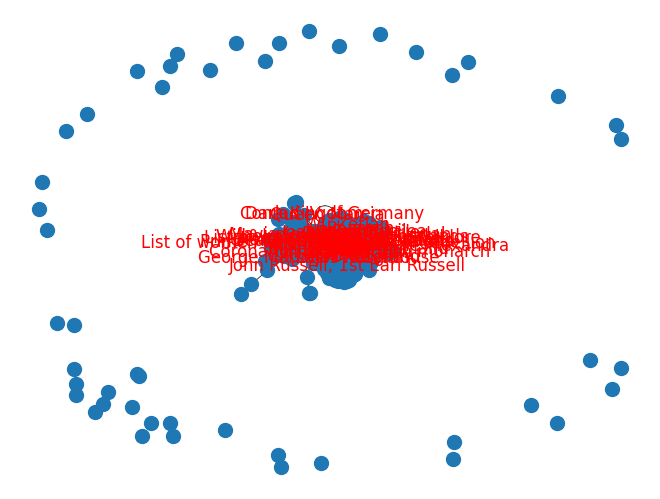

In [346]:
nx.draw(subgraph, with_labels=False, font_size=12, font_weight ='bold',node_size=100, width=0.5)
nx.draw_networkx_labels(subgraph, pos=nx.spring_layout(subgraph), labels=labels, font_color='red')
plt.show()


# pagerank

In [139]:
pagerank = nx.pagerank(G)
pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
df_pagerank = pd.DataFrame(pagerank, columns=['Article', 'PageRank'])
df_pagerank['name'] = df_pagerank['Article'].apply(lambda x: article_name(x))

In [148]:
df_pagerank

,Article,PageRank,name
0,279122,7.576416e-03,United States
1,987583,4.685716e-03,France
2,987710,3.165334e-03,Departments of France
3,987709,3.053998e-03,Communes of France
4,1313472,2.901595e-03,Gmina
...,...,...,...
1791484,256967,8.379008e-08,Nathaniel Batts
1791485,1332004,8.378366e-08,International Women's Sports Federation
1791486,1488796,8.377914e-08,Catherine Philp
1791487,1701229,8.376964e-08,Don Richardson (musician)


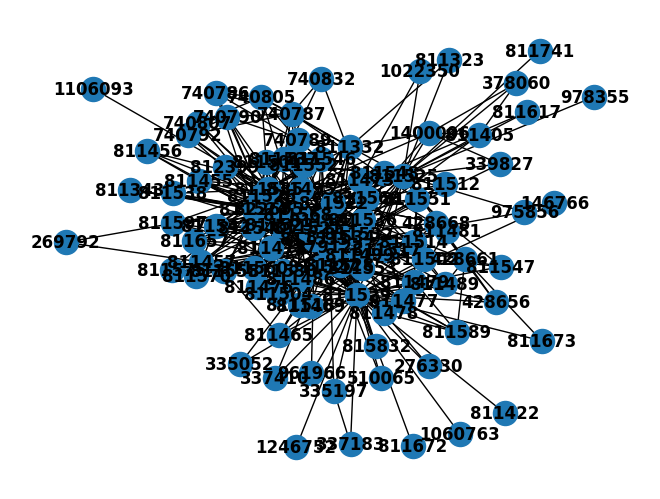

# all centrality measures

In [26]:
df = pd.DataFrame(nx.out_degree_centrality(G), index=['degree_centrality']).T

In [27]:
df['article'] = df.index.map(article_name)

In [28]:
df.sort_values('degree_centrality', ascending=False).reset_index(drop=True).to_csv('finished_files/out_degree_centrality.csv')

In [29]:
ec = nx.eigenvector_centrality(G)

In [30]:
df_ec = pd.DataFrame(ec, index=['eigenvector_centrality']).T

In [31]:
df_ec['article'] = df.index.map(article_name)

In [32]:
df_ec.sort_values('eigenvector_centrality',ascending=False).reset_index(drop=True).to_csv('finished_files/eigenvector_centrality.csv')

In [33]:
pr = nx.pagerank(G)

In [34]:
df_pr = pd.DataFrame(pr, index=['pagerank']).T

In [35]:
df_pr['article'] = df.index.map(article_name)

In [36]:
df_pr.sort_values('pagerank',ascending=False).reset_index(drop=True).to_csv('finished_files/pagerank.csv')

# sample

greedy_modularity_communities

In [5]:
sg = G.subgraph(random.sample(list(G.nodes()), 10000))

In [11]:
f = nx.community.greedy_modularity_communities(sg, cutoff=10,best_n=10) # not sure what this is
f = sorted(f)

In [12]:
f = sorted(f)

mean clustering of random sample of 100 nodes 

In [55]:
import numpy as np
for n in range(10):
    l = random.sample(list(G.nodes()), 1000)
    print(np.mean([nx.clustering(G,x) for x in l]))

0.18479236266333432
0.1754362962548023
0.17802695639172592
0.17825354909687638
0.18746692037430698
0.17935901177299807
0.18928010493294292
0.17897315149057755
0.18363855104338545
0.17672758332658994


In [7]:
cliques = nx.find_cliques(G.to_undirected())

In [14]:
cliques

<generator object find_cliques at 0x7f6c2f428740>

In [8]:
sorted_cliques = sorted(cliques, key=len, reverse=True)

KeyboardInterrupt: 

In [ ]:
[len(x) for x in sorted_cliques]